# Ensemble of the best models: gaussian_mix, kmeans_opt, fuzzy

Try kmeans + gaussian_mix; kmeans + fuzzy; gaussian_mix + fuzzy; fuzzy + gaussian_mix + ward_link_opt 

In [36]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import skfuzzy as fuzz
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist

In [37]:
df = pd.read_csv('../2_models/with_clean_data/wind/pca_df.csv')
subset_df = pd.read_csv('../2_models/with_clean_data/wind/df_subset.csv')

In [38]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

## K-Means with optimized parameters + Gaussian Mix

In [39]:
# K-Means:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

# Gaussian Mixture:
gmm = GaussianMixture(n_components=8, random_state=1, verbose=1)
gmm_labels = gmm.fit_predict(df)

KMeans is done
Initialization 0


  Iteration 10
Initialization converged: True


In [40]:
with open('results/clean_wind/gmm.pickle', 'wb') as f:
    pickle.dump(gmm, f)

with open('results/clean_wind/kmeans.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [41]:
with open('results/clean_wind/gmm.pickle', 'rb') as f:
    gmm = pickle.load(f)
gmm_labels = gmm.fit_predict(df)

with open('results/clean_wind/kmeans.pickle', 'rb') as f:
    kmeans = pickle.load(f)
kmeans_labels = kmeans.fit_predict(df)

Initialization 0
  Iteration 10
Initialization converged: True


Ensemble Construction by Major Voting: selecting the cluster with the highest number of votes

In [42]:
# Voting based on cluster assignments
num_clusters = max(len(set(kmeans_labels)), len(set(gmm_labels)))
voting_labels_kmeans_gmm = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    gmm_cluster = gmm_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[kmeans_cluster] += 1
    votes[gmm_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_kmeans_gmm[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [43]:
def dunn_index(points = np.array(df), labels = voting_labels_kmeans_gmm):
    min_intercluster_distances = []
    max_intracluster_distances = []
    
    for label in np.unique(labels):
        cluster_points = points[labels == label]
        if len(cluster_points) > 1:
            intracluster_distances = pairwise_distances(cluster_points)
            max_intracluster_distances.append(np.max(intracluster_distances))
        
        for other_label in np.unique(labels):
            if label != other_label:
                other_cluster_points = points[labels == other_label]
                intercluster_distances = pairwise_distances(cluster_points, other_cluster_points)
                min_intercluster_distances.append(np.min(intercluster_distances))
    
    if len(max_intracluster_distances) == 0 or len(min_intercluster_distances) == 0:
        return 0
    
    return min(min_intercluster_distances) / max(max_intracluster_distances)


In [44]:
def xie_beni_index(points = np.array(df), labels = voting_labels_kmeans_gmm):
    # Compute the total scatter
    total_scatter = np.sum(pairwise_distances(points) ** 2) / (2 * len(points))
    
    # Compute the intra-cluster scatter
    cluster_labels = np.unique(labels)
    intra_cluster_scatter = 0
    for label in cluster_labels:
        cluster_points = points[labels == label]
        cluster_center = np.mean(cluster_points, axis=0)
        intra_cluster_scatter += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1) ** 2)
    intra_cluster_scatter /= len(points)
    
    return intra_cluster_scatter / total_scatter


In [45]:
# Define a function to compute evaluation metrics
def compute_metrics(points = np.array(df), labels = voting_labels_kmeans_gmm):

    metrics = {}
    
    metrics['Silhouette Score'] = silhouette_score(points, labels)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(points, labels)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(points, labels)
    metrics['Dunn Index'] = dunn_index(points, labels)
    metrics['Xie-Beni Index'] = xie_beni_index(points, labels)

    return metrics


Ensemble Construction by Weighted Averaging:

In [46]:
df['cluster_label'] = voting_labels_kmeans_gmm
df['asset_id'] = subset_df['asset_id']

In [47]:
df.to_csv('results/clean_wind/gmm_kmeans.csv', index = False)

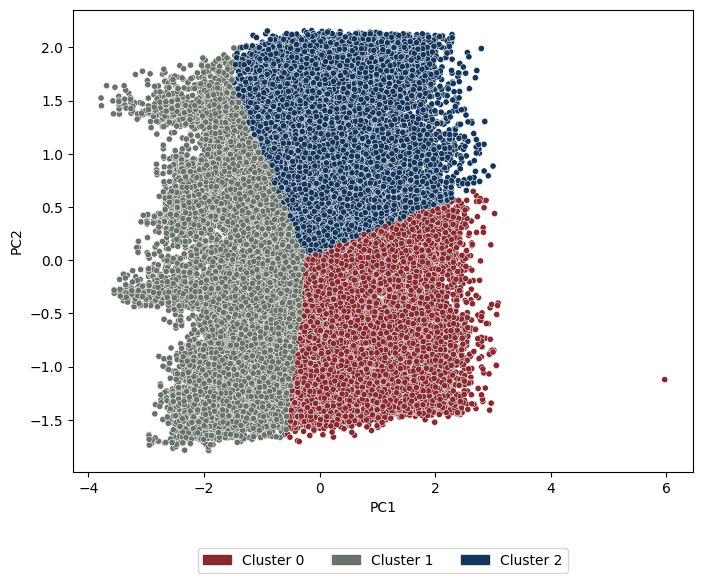

In [48]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_kmeans_gmm)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [49]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,2
1,0.449997,0.756881,11,2
2,1.051556,1.451060,11,2
3,-0.911238,-0.388945,11,2
4,1.337903,1.479679,11,2


In [50]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,2
1,12,0.251166,0.669049,2
2,13,-1.229941,-0.226747,1
3,14,-0.713823,1.031153,1
4,15,-0.987418,1.580407,2
...,...,...,...,...
66,414,-0.870138,0.643293,2
67,415,-0.623235,1.262525,2
68,510,-1.782868,-0.200945,0
69,511,-0.132724,-1.307785,0


In [51]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [5, 10, 12, 13, 18, 20, 22, 27, 28, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 54, 56, 60, 61, 62, 65, 68, 69, 70]
Cluster 1: [2, 3, 6, 7, 8, 46, 50, 51, 52]
Cluster 2: [0, 1, 4, 9, 11, 14, 15, 16, 17, 19, 21, 23, 24, 25, 26, 29, 30, 31, 33, 34, 45, 47, 48, 49, 53, 55, 57, 58, 59, 63, 64, 66, 67]


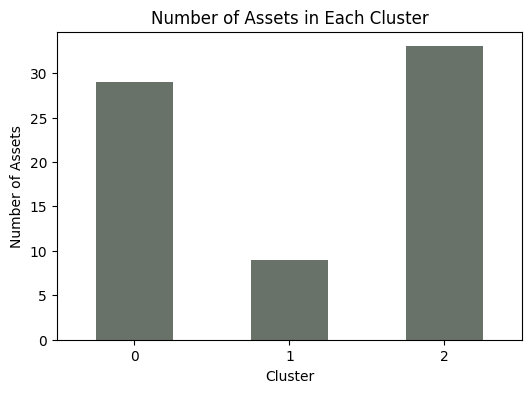

In [52]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [53]:
df = df[['PC1', 'PC2']]
df['cluster_label'] = voting_labels_kmeans_gmm

### Metrics

In [54]:
# Initialize an empty list to store the results
results = []

# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics()
results.append({'Model': 'gmm + kmeans_opt', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [55]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans_opt,0.382288,0.873197,34106.950814,0.000374,0.000009


## K-Means + Fuzzy C-Means

In [56]:
df = df[['PC1', 'PC2']]

In [57]:
# K-Means:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

# Fuzzy C-Means
num_clusters = 5
fuzziness = 2 

# Apply Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    df.T, num_clusters, fuzziness, error=0.005, maxiter=1000, init=None)

KMeans is done


In [58]:
cluster_membership = u.T
fuzzy_labels = np.argmax(cluster_membership, axis=1)

# Voting based on cluster assignments
num_clusters = max(len(set(kmeans_labels)), len(set(fuzzy_labels)))
voting_labels_kmeans_fuzzy = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    fuzzy_cluster = fuzzy_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[kmeans_cluster] += 1
    votes[fuzzy_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_kmeans_fuzzy[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [59]:
df['cluster_label'] = voting_labels_kmeans_fuzzy
df['asset_id'] = subset_df['asset_id']

In [60]:
df.to_csv('results/clean_wind/fuzzy_kmeans.csv', index = False)

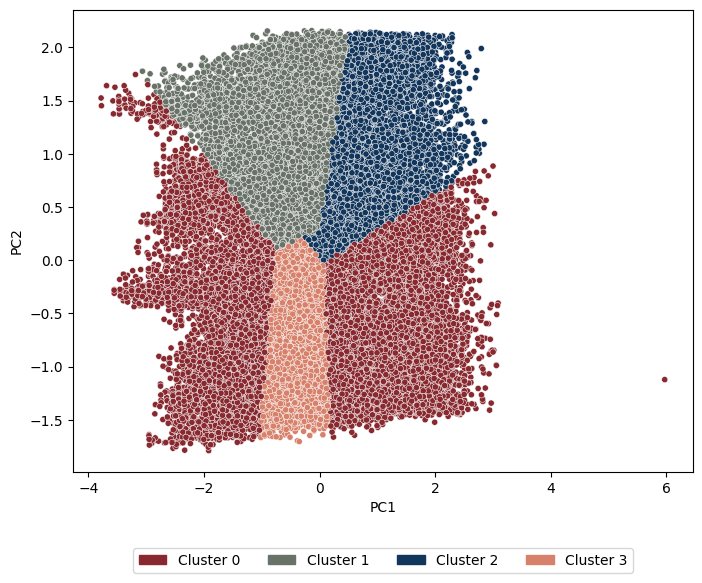

In [61]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means and Fuzzy C-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_kmeans_fuzzy)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [62]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,0
1,0.449997,0.756881,11,0
2,1.051556,1.451060,11,0
3,-0.911238,-0.388945,11,0
4,1.337903,1.479679,11,0


In [63]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,0
1,12,0.251166,0.669049,1
2,13,-1.229941,-0.226747,0
3,14,-0.713823,1.031153,0
4,15,-0.987418,1.580407,0
...,...,...,...,...
66,414,-0.870138,0.643293,0
67,415,-0.623235,1.262525,0
68,510,-1.782868,-0.200945,0
69,511,-0.132724,-1.307785,0


In [64]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
Cluster 1: [1, 17]
Cluster 2: [11]


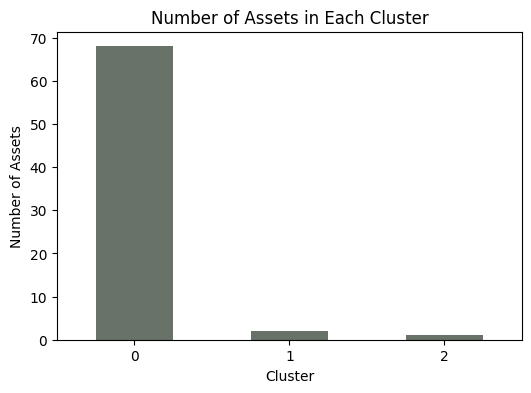

In [65]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [66]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_kmeans_fuzzy)
results.append({'Model': 'fuzzy + kmeans', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [67]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans_opt,0.382288,0.873197,34106.950814,0.000374,0.000009
1,fuzzy + kmeans,0.103717,2.976254,9448.751905,0.000394,0.000014


## Gaussian Mixture + Fuzzy C-Means

Ensemble Construction by Cluster Fusion:

Cluster Fusion: Merge clusters from K-means and GMMs based on similarity measures between cluster centroids or density distributions

In [68]:
df = df[['PC1', 'PC2']]

In [69]:
# Voting based on cluster assignments
num_clusters = max(len(set(fuzzy_labels)), len(set(gmm_labels)))
voting_labels_fuzzy_gmm = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    fuzzy_cluster = fuzzy_labels[i]
    gmm_cluster = gmm_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[fuzzy_cluster] += 1
    votes[gmm_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_fuzzy_gmm[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [70]:
df['cluster_label'] = voting_labels_fuzzy_gmm
df['asset_id'] = subset_df['asset_id']

In [71]:
df.to_csv('results/clean_wind/gmm_fuzzy.csv', index = False)

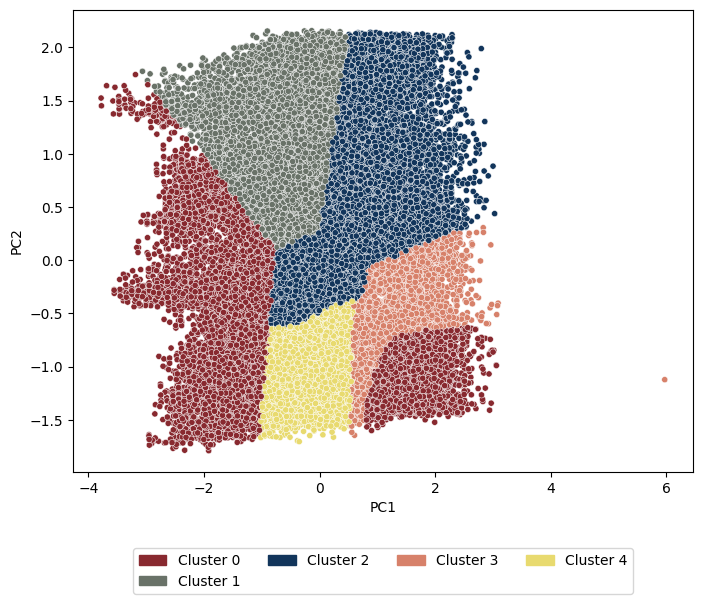

In [72]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble Fuzzy C-Means and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_fuzzy_gmm)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [73]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,2
1,0.449997,0.756881,11,2
2,1.051556,1.451060,11,2
3,-0.911238,-0.388945,11,2
4,1.337903,1.479679,11,2


In [74]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,2
1,12,0.251166,0.669049,1
2,13,-1.229941,-0.226747,0
3,14,-0.713823,1.031153,0
4,15,-0.987418,1.580407,2
...,...,...,...,...
66,414,-0.870138,0.643293,2
67,415,-0.623235,1.262525,2
68,510,-1.782868,-0.200945,0
69,511,-0.132724,-1.307785,0


In [75]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [2, 3, 7, 8, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 50, 51, 52, 68, 69, 70]
Cluster 1: [1, 6, 17, 47, 48]
Cluster 2: [0, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 49, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


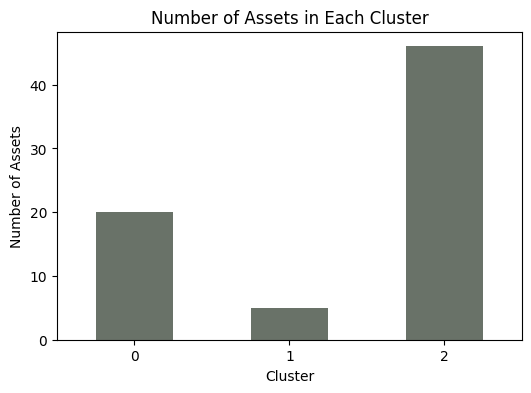

In [76]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [77]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_fuzzy_gmm)
results.append({'Model': 'gmm + fuzzy', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [78]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans_opt,0.382288,0.873197,34106.950814,0.000374,0.000009
1,fuzzy + kmeans,0.103717,2.976254,9448.751905,0.000394,0.000014
2,gmm + fuzzy,0.142893,1.905174,10158.573624,0.000167,0.000012


## GMM + K-Means + Fuzzy C-Means

In [79]:
df = df[['PC1', 'PC2']]

In [80]:
# # K-Means:
# kmeans = KMeans(n_clusters=4, random_state=1)
# kmeans_labels = kmeans.fit_predict(df)

# print('KMeans is done')

# # Fuzzy C-Means
# num_clusters = 5
# fuzziness = 2 

# # Apply Fuzzy C-means clustering
# cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
#     df.T, num_clusters, fuzziness, error=0.005, maxiter=1000, init=None)

# # Extract cluster membership probabilities
# cluster_membership = u.T

# # Assign data points to clusters based on membership probabilities
# fuzzy_labels = np.argmax(cluster_membership, axis=1)

# print('Fuzzy C-Means is done')

# # Gaussian Mixture:
# gmm = GaussianMixture(n_components=5, random_state=1, verbose=1)
# gmm_labels = gmm.fit_predict(df)

Ensemble Construction by Cluster Fusion:

In [81]:
voting_labels_all = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    gmm_cluster = gmm_labels[i]
    fuzzy_cluster = fuzzy_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[kmeans_cluster] += 1
    votes[gmm_cluster] += 1
    votes[fuzzy_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_all[i] = np.argmax(votes)

print('Voting based method is done')


Voting based method is done


In [82]:
df['cluster_label'] = voting_labels_all
df['asset_id'] = subset_df['asset_id']

In [83]:
df.to_csv('results/clean_wind/fuzzy_kmeans_gmm.csv', index = False)

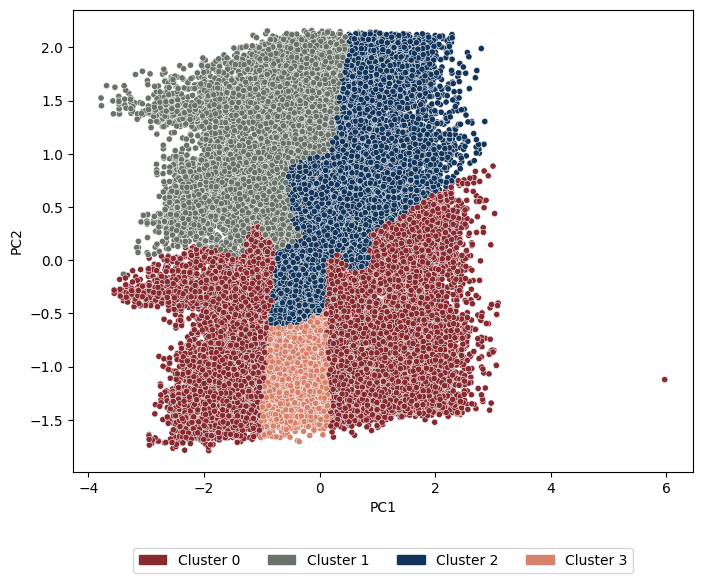

In [84]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means, Fuzzy C-Means and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_all)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [85]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,2
1,0.449997,0.756881,11,2
2,1.051556,1.451060,11,2
3,-0.911238,-0.388945,11,2
4,1.337903,1.479679,11,2


In [86]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,2
1,12,0.251166,0.669049,1
2,13,-1.229941,-0.226747,0
3,14,-0.713823,1.031153,0
4,15,-0.987418,1.580407,0
...,...,...,...,...
66,414,-0.870138,0.643293,0
67,415,-0.623235,1.262525,2
68,510,-1.782868,-0.200945,0
69,511,-0.132724,-1.307785,0


In [87]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 65, 66, 68, 69, 70]
Cluster 1: [1, 6, 47]
Cluster 2: [0, 11, 15, 17, 23, 24, 33, 35, 45, 48, 57, 63, 64, 67]


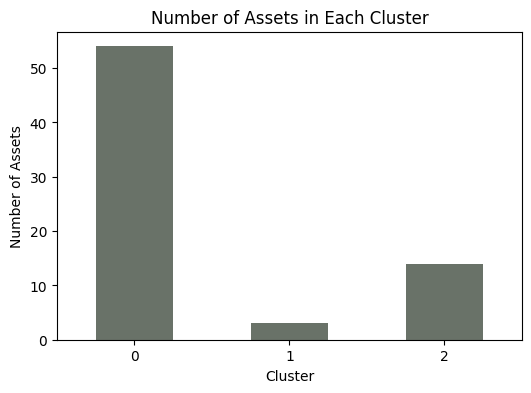

In [88]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [89]:
df = df[['PC1', 'PC2']]
df['cluster_label'] = voting_labels_all

### Metrics

In [90]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_all)
results.append({'Model': 'fuzzy + kmeans + gmm', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [91]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans_opt,0.382288,0.873197,34106.950814,0.000374,0.000009
1,fuzzy + kmeans,0.103717,2.976254,9448.751905,0.000394,0.000014
2,gmm + fuzzy,0.142893,1.905174,10158.573624,0.000167,0.000012
3,fuzzy + kmeans + gmm,0.100231,2.059334,10499.624555,0.000283,0.000013


In [92]:
normalized_df = results_df.copy()

# Define ideal and anti-ideal solutions for each metric
ideal_solution = normalized_df.copy()
anti_ideal_solution = normalized_df.copy()

# Define metrics where higher values are better
higher_is_better = ['Silhouette Score', 'Dunn Index', 'Calinski-Harabasz Index']

# Define metrics where lower values are better
lower_is_better = ['Davies-Bouldin Index', 'Xie-Beni Index']

# Set ideal and anti-ideal solutions for metrics where higher values are better
for metric in higher_is_better:
    ideal_solution[metric] = normalized_df[metric].max()
    anti_ideal_solution[metric] = normalized_df[metric].min()

# Set ideal and anti-ideal solutions for metrics where lower values are better
for metric in lower_is_better:
    ideal_solution[metric] = normalized_df[metric].min()
    anti_ideal_solution[metric] = normalized_df[metric].max()

# Calculate the distance from each alternative to the ideal and anti-ideal solutions
dist_to_ideal = ((normalized_df.iloc[:,1:] - ideal_solution) ** 2).sum(axis=1) ** 0.5
dist_to_anti_ideal = ((normalized_df.iloc[:,1:] - anti_ideal_solution) ** 2).sum(axis=1) ** 0.5

# Calculate the relative closeness to the ideal solution --> the one that has the bigger distance from the anti-ideal solution is the one thats closer to the ideal solution
normalized_df['Closeness'] = dist_to_anti_ideal / (dist_to_ideal + dist_to_anti_ideal)

# Sort the models based on their relative closeness to the ideal solution
ranked_models = normalized_df.sort_values(by='Closeness', ascending=False)

# Print the ranked models
ranked_models[['Model', 'Closeness']]

,Model,Closeness
0,gmm + kmeans_opt,1.000000e+00
3,fuzzy + kmeans + gmm,4.261759e-02
2,gmm + fuzzy,2.878647e-02
1,fuzzy + kmeans,1.416746e-07


gmm + kmeans_opt is the best

In [93]:
with open('results/clean_wind/results.pickle', 'wb') as f:
    pickle.dump(results,f)

results_df.to_csv('results/clean_wind/results.csv', index=False)